In [115]:
import mailbox
import pandas as pd
from bs4 import BeautifulSoup as bs
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [86]:
from bs4 import BeautifulSoup as bs
import mailbox
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

#import nltk.corpus
#nltk.download('stopwords')
#nltk.download('wordnet')
#from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer

In [19]:
df = pd.read_pickle('/root/work/_Temp/StartUp/startup.pkl')

In [20]:
X_train = df['clear_text']
y_train = df['target']

In [21]:
df['target'].value_counts()

1    10659
0     4391
Name: target, dtype: int64

In [72]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', SGDClassifier(loss='modified_huber')),
])

# Поиск лучших гиперпараметров
parameters = {
    'vec__max_features': (None, 100, 200, 300, 500, 700, 1000, 1500, 2000),
    'vec__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),
    'clf__alpha': (0.0001, 0.00001, 0.000001),
    'clf__penalty': ('l1', 'l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80, 90, 120, 150),
}

gs_sgd = GridSearchCV(
    pipeline, parameters, 
    scoring='roc_auc',
    n_jobs=-1, 
    verbose=1)
gs_sgd.fit(X_train, y_train)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


GridSearchCV(estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('clf',
                                        SGDClassifier(loss='modified_huber'))]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.0001, 1e-05, 1e-06),
                         'clf__max_iter': (10, 50, 80, 90, 120, 150),
                         'clf__penalty': ('l1', 'l2', 'elasticnet'),
                         'vec__max_features': (None, 100, 200, 300, 500, 700,
                                               1000, 1500, 2000),
                         'vec__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4))},
             scoring='roc_auc', verbose=1)

In [73]:
print('ROC AUC:', round(gs_sgd.best_score_, 3))
print('Лучшие гиперпараметры:')
gs_sgd.best_params_

ROC AUC: 0.763
Лучшие гиперпараметры:


{'clf__alpha': 1e-05,
 'clf__max_iter': 120,
 'clf__penalty': 'l1',
 'vec__max_features': 100,
 'vec__ngram_range': (1, 4)}

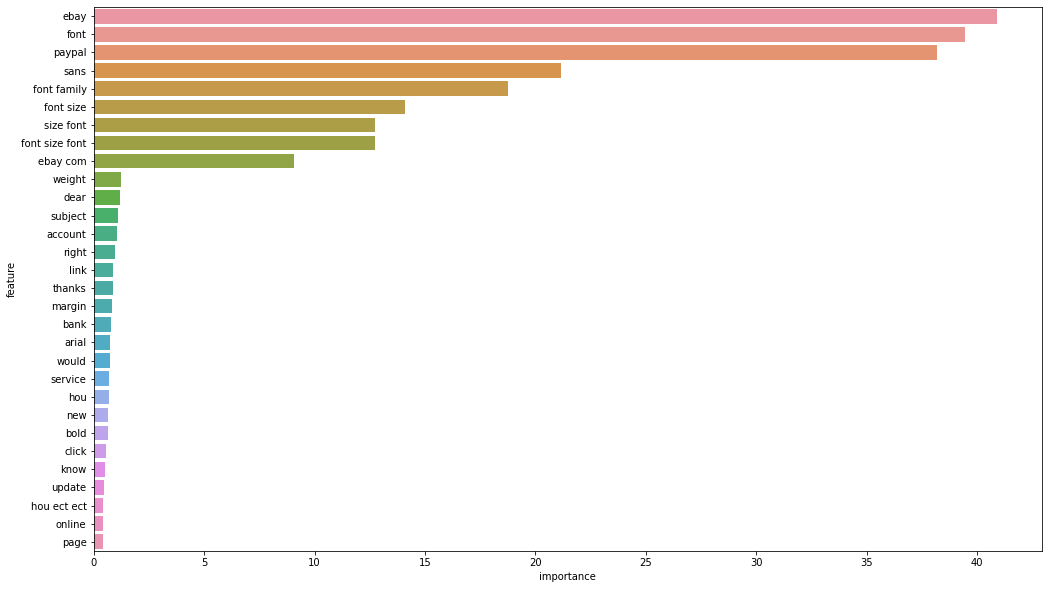

In [74]:
feature_name = gs_sgd.best_estimator_.named_steps['vec'].get_feature_names()
coef = gs_sgd.best_estimator_.named_steps['clf'].coef_.flatten()

importance = pd.DataFrame({
    'feature': feature_name,
    'importance': abs(coef)
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(17,10))
sns.barplot(data=importance[:30], x='importance', y='feature', orient='h');

In [113]:
preds = df.query('target == 1').copy()
preds['score'] = gs_sgd.predict_proba(preds['clear_text'])[:,1]
preds = preds.rename(columns={'id':'UID'})
preds['VERDICT'] = (preds['score'] < 0.75).astype(int)
preds

,UID,date,from,subject,content,content_type,raw_message,target,clear_text,score,VERDICT
0,25ca3d36cc8af3ca00458e0b03d8e479348f369f,"Thu, 18 Jan 2001 05:59:00 -0800 (PST)",vince.kaminski@enron.com,1 Candidate and 2 interns,"Bryan\n\nPlease, take a look at the resume of ...",text/plain; charset=us-ascii,"[Date, From, Subject, Content-Type, X-UID]",1,bryan please take look resume howard haughton ...,0.545102,1
1,6572c93686a1ade674d3d3f91d8d8ecf7f032ed9,"Fri, 29 Sep 2000 07:02:00 -0700 (PDT)",tori.kuykendall@enron.com,Bank of the West customer service informs you!...,\n\n\n\nDear Bank of the West ...,"multipart/alternative;\n\tboundary=""--74KHQI_Z...","[Subject, Content-Type, From, Date, X-UID]",1,dear bank west client bank west customer servi...,1.000000,0
2,8cc9b26251dc2e3c1d8e04d94a1ebeecb7b2911f,"Thu, 13 Apr 2000 10:16:00 -0700 (PDT)",kimberly.brown@enron.com,eBay - Important Notice,"Dear eBay Customer,We recently noticed \none o...","text/html;\n\tcharset=""Windows-1251""","[Subject, Content-Type, From, Date, X-UID]",1,dear ebay customer recently noticed one attemp...,1.000000,0
3,6d721e2e962c579a1030818aec94483b567d72bc,"Fri, 18 Aug 2000 02:08:00 -0700 (PDT)",cathy.phillips@enron.com,Re-Confirm Online Acess,\n\n\n\n\nBank of America Internal Mail Box No...,text/html,"[Subject, Content-Type, From, Date, X-UID]",1,bank america internal mail box notification me...,1.000000,0
4,3306a3d19f4d6ed5de0a09e3bc5e4d536757852e,"Fri, 27 Oct 2000 04:32:00 -0700 (PDT)",karen.heathman@enron.com,Your account access has been limited,\n\n\nLimited Account Access Details\n\n\n\n\n...,"text/html;\n\tcharset=""Windows-1251""","[Subject, Content-Type, From, Date, X-UID]",1,limited account access detail pp_footer font f...,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
10654,d147daa868084ace58c4921e6911c7fef5712460,"Tue, 2 May 2000 07:36:00 -0700 (PDT)",susan.scott@enron.com,Re: FW: GIR Settlement Hearings - Practice Cro...,Sounds like a great idea -- let us know where/...,text/plain; charset=us-ascii,"[Date, From, Subject, Content-Type, X-UID]",1,sound like great idea let know,0.451324,1
10655,b59c16dc71d8597df5089d7b137c56b89e5de872,"Mon, 19 Mar 2001 23:59:00 -0800 (PST)",dan.hyvl@enron.com,Re: crestar / gulf aos contract....,"Grant,\n The problem is that they do not want ...",text/plain; charset=us-ascii,"[Date, From, Subject, Content-Type, X-UID]",1,grant problem want assign agreement want parti...,0.296836,1
10656,5e718031cc33a08c9c8845f9b3f032d016ef5be6,"Wed, 18 Apr 2001 18:37:00 -0700 (PDT)",james.derrick@enron.com,Question about item #260067307240 AIR-ZONE� PR...,\n\n\n\neBay sent this message to eBay Member....,"multipart/alternative;\n\tboundary=""--26956222...","[Subject, Content-Type, From, Date, X-UID]",1,ebay sent message ebay member registered nam i...,1.000000,0
10657,f98e2fd421519b36376dc6dbb19964e7d9c6cdff,"Fri, 9 Feb 2001 03:34:00 -0800 (PST)",steven.south@enron.com,Verify your Paypal Account,We recently have determined that different com...,"text/html;\n\tcharset=""Windows-1251""","[Subject, Content-Type, From, Date, X-UID]",1,recently determined different computer logged ...,1.000000,0


In [105]:
preds[['UID','VERDICT']].to_csv('/root/work/_Temp/StartUp/sub_1.csv', index=False)

In [103]:
preds[['UID','VERDICT']].to_csv('/root/work/_Temp/StartUp/sub_09.csv', index=False)

In [107]:
preds[['UID','VERDICT']].to_csv('/root/work/_Temp/StartUp/sub_095.csv', index=False)

In [110]:
preds[['UID','VERDICT']].to_csv('/root/work/_Temp/StartUp/sub_085.csv', index=False)

In [112]:
preds[['UID','VERDICT']].to_csv('/root/work/_Temp/StartUp/sub_08.csv', index=False)

In [114]:
preds[['UID','VERDICT']].to_csv('/root/work/_Temp/StartUp/sub_075.csv', index=False)

In [108]:
preds['VERDICT'].sum()

5425

In [116]:
with open('/root/work/_Temp/StartUp/model1.pkl', 'wb') as f:
    pickle.dump(gs_sgd, f)

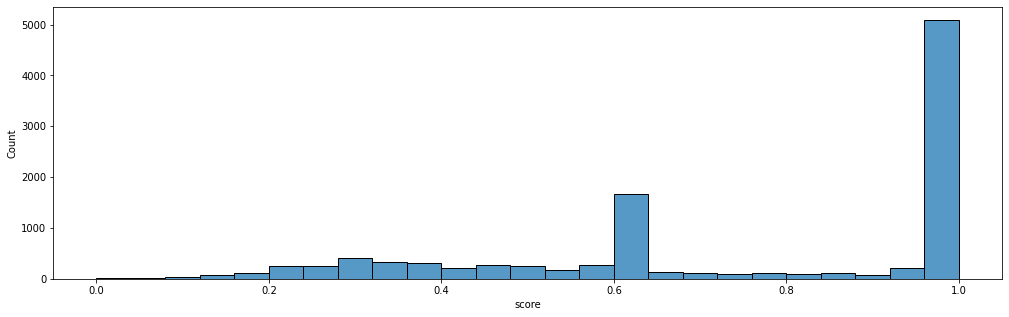

In [82]:
plt.figure(figsize=(17,5))
sns.histplot(preds['score']);

In [87]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    #('dec', TruncatedSVD()),
    ('clf', RandomForestClassifier()),
])

parameters = {
    'vec__max_features': (100, 200, 300, 500, 700, 1000),
    'vec__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),
    #'dec__n_components': [300],
    'clf__n_estimators': [100],
    'clf__max_depth': [5,10,15,20],
}

# Поиск лучших гиперпараметров
gs_rf = GridSearchCV(
    pipeline, parameters, 
    scoring='roc_auc',
    n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [5, 10, 15, 20],
                         'clf__n_estimators': [100],
                         'vec__max_features': (100, 200, 300, 500, 700, 1000),
                         'vec__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4))},
             scoring='roc_auc', verbose=1)

In [88]:
print('ROC AUC:', round(gs_rf.best_score_, 3))
print('Лучшие гиперпараметры:')
gs_rf.best_params_

ROC AUC: 0.767
Лучшие гиперпараметры:


{'clf__max_depth': 5,
 'clf__n_estimators': 100,
 'vec__max_features': 100,
 'vec__ngram_range': (1, 4)}